# Ramsey Experiment

<div class="admonition goal">
    <p class="admonition-title">Goal</p>
    <p>
        This tutorial demonstrate how can you use the framework to perform Ramsey experiment using our simulator. This tutorial serves as a showcase of how you can use control to to modify the behavior of the simulator. 
    </p>
</div>

In [1]:
import jax
import jax.numpy as jnp
import inspeqtor as sq
from functools import partial

## Define control

Let's over engineer our control sequence in this example. Since, we use a simulator, we can "cheat" by initialize a quantum state into $|+\rangle$ and measurement Pauli-X directly. However, let us not cheat and do it like a giga chad 💪. We first define the atomic control, a controllable delayed $\pi / 2$  rotation around X-axis at the start and end of the sequence.

In [ ]:
from dataclasses import dataclass


@dataclass
class DelayedX(sq.control.BaseControl):
    max_idle_time: float
    qubit_drive_strength: float
    dt: float
    max_amp: float = 0.25
    theta: float = jnp.pi / 2
    offset: float = 0.0

    def __post_init__(self):
        # This is the correction factor that will cancel the factor in the front of hamiltonian
        self.correction = 2 * jnp.pi * self.qubit_drive_strength * self.dt

        # The standard derivation of Gaussian pulse is keep fixed for the given max_amp
        self.sigma = jnp.sqrt(2 * jnp.pi) / (self.max_amp * self.correction)

    def get_bounds(
        self,
    ) -> tuple[sq.control.ParametersDictType, sq.control.ParametersDictType]:
        lower: sq.control.ParametersDictType = {
            "t": 0.0,
        }
        upper: sq.control.ParametersDictType = {
            "t": self.max_idle_time,
        }

        return lower, upper

    def get_envelope(self, params: sq.control.ParametersDictType):
        # The area of Gaussian to be rotate to,
        area = (
            self.theta / self.correction
        )  # NOTE: Choice of area is arbitrary e.g. pi pulse
        center_position = params["t"] + self.offset

        return sq.control.library.gaussian_envelope(
            amp=area, center=center_position, sigma=self.sigma
        )


total_dt = 1000
dt = 0.5

qubit_info = sq.data.library.get_mock_qubit_information()

ctrl_seq = sq.control.ControlSequence(
    controls={
        "start": DelayedX(
            max_idle_time=total_dt,
            qubit_drive_strength=qubit_info.drive_strength,
            dt=dt,
            max_amp=1.0,
            offset=50.0,
        ),
        "end": DelayedX(
            max_idle_time=total_dt,
            qubit_drive_strength=qubit_info.drive_strength,
            dt=dt,
            max_amp=1.0,
            offset=-50.0,
        ),
    },
    total_dt=total_dt,
)
ravel_fn, unravel_fn = sq.control.ravel_unravel_fn(ctrl_seq.get_structure())

We can visualize our lovely pulse sequence as usual.

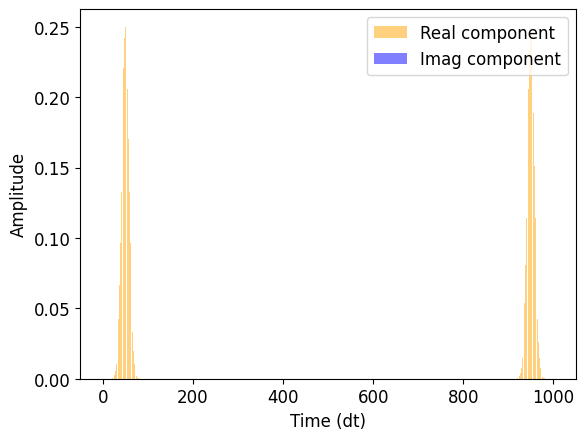

In [3]:
import matplotlib.pyplot as plt

param: dict[str, sq.control.ParametersDictType] = {
    "start": {"t": jnp.array(0)},
    "end": {"t": jnp.array(total_dt)},
}

t_eval = jnp.linspace(0, total_dt, total_dt + 1)
waveform = jax.vmap(ctrl_seq.get_envelope(param))(t_eval)
fig, ax = plt.subplots()
sq.utils.plot_control_envelope(waveform, t_eval, ax)

## Prepare the simulator

In this case, we would like to have a fine-grained control over the simulator, so we are going to define a custom transmon Hamiltonain in rotating frame. The part that needed beyond the predefined version is the "detune" free evolution of the qubit. In this case, we turn on the detune at $100 < t < T_{\rm end} - 100$.

In [ ]:
import typing


def rotating_transmon_hamiltonian(
    params,
    t: jnp.ndarray,
    qubit_info: sq.data.QubitInformation,
    signal: typing.Callable[..., jnp.ndarray],
) -> jnp.ndarray:
    a0 = 2 * jnp.pi * qubit_info.frequency
    a1 = 2 * jnp.pi * qubit_info.drive_strength

    def f_sigma_x(params, t):
        return a1 * signal(params, t) * jnp.cos(a0 * t)

    def f_sigma_y(params, t):
        return a1 * signal(params, t) * jnp.sin(a0 * t)

    def piecewise(params, t):
        detune_freq = 0.005

        return jnp.piecewise(
            t, [t < 100, t > params["end"]["t"] - 100], [0.0, 0.0, detune_freq]
        )

    return (
        f_sigma_x(params, t) * sq.utils.X
        - f_sigma_y(params, t) * sq.utils.Y
        + a0 * 0.5 * sq.utils.Z * piecewise(params, t)
    )


def shot_quantum_device(
    key: jnp.ndarray,
    param,
    initial_state: jnp.ndarray,
    observable: jnp.ndarray,
    shots: int,
    hamiltonian,
    lindblad_ops,
):
    # Solver is a function that return the final density matrix in this case
    # calculate the final density matrix
    t_eval = jnp.array([param["start"]["t"], param["end"]["t"]])
    dm = sq.physics.lindblad_solver(
        args=param,
        t_eval=t_eval,
        hamiltonian=hamiltonian,
        lindblad_ops=lindblad_ops,
        rho0=initial_state,
        t0=param["start"]["t"],  # type: ignore
        t1=param["end"]["t"],  # type: ignore
        max_steps=int(2**17),
    )[-1]

    return sq.utils.calculate_shots_expectation_value(
        key, dm, unitary=jnp.eye(2), operator=observable, shots=shots
    )

## Simulate the experiment.

Since, we perform an experiment that did not required sampling of the control sequence, we simply construct the control parameter for each sequence directly. Typically, for Ramsey experiment, we refer the decoherence time of the phase as $T_2^*$, but to keep it brief, we keep the variable name as `T2`. 

In [9]:
key = jax.random.key(0)
initial_state = sq.data.get_initial_state("0", dm=True)

sample_size = 201
shots = 1000

t_end = jnp.linspace(300, total_dt, sample_size).reshape(-1, 1)
t_start = jnp.zeros_like(t_end).reshape(-1, 1)

t_evals = jnp.hstack([t_start, t_end])
# Indeed, we can vmap the flat parameters to the structured one.
t_evals = jax.vmap(unravel_fn)(t_evals)

# Define the device from functions above.
T2 = 500  # This is the value that we want to infer.
gamma_phi = 1 / T2  # Decay rate
L_dephase = jnp.sqrt(gamma_phi) * sq.utils.Z

drive_freq = qubit_info.frequency * 1.00
signal_fn = sq.physics.make_signal_fn(
    ctrl_seq.get_envelope,
    drive_frequency=drive_freq,
    dt=dt,
)

hamiltonian = partial(
    rotating_transmon_hamiltonian,
    qubit_info=qubit_info,
    signal=signal_fn,
)

device = partial(
    shot_quantum_device,
    initial_state=initial_state,
    observable=sq.utils.Z,
    shots=shots,
    hamiltonian=hamiltonian,
    lindblad_ops=[L_dephase],
)

# And we can vmap over the structured parameters too!
finite_shot_expvals = jax.vmap(device, in_axes=(None, 0))(key, t_evals)

Now we can visualize the experimental data as usual.

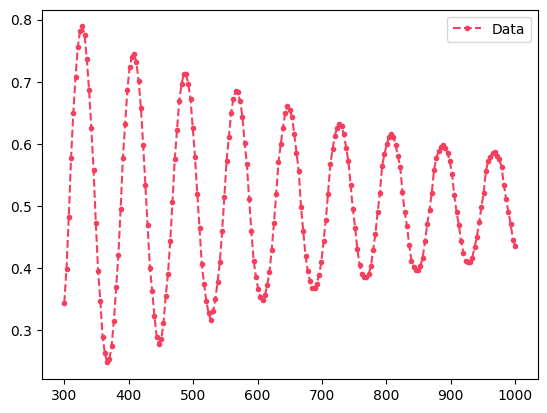

In [10]:
import matplotlib.pyplot as plt

# Visualization
population = sq.utils.expectation_value_to_prob_minus(finite_shot_expvals)
plt.plot(t_end.reshape(-1), population, ".--", color=sq.utils.colors.red, label='Data')
plt.legend()

## Save the data

We can save the experiment using the same flow as the channel characterization. 

In [ ]:
import polars as pl
import numpy as np
from flax.traverse_util import flatten_dict

expectation_values = finite_shot_expvals.reshape(1, -1)
order = [sq.data.ExpectationValue("0", "Z")]
config = sq.data.ExperimentConfiguration(
    qubits=[qubit_info],
    expectation_values_order=order,
    parameter_structure=ctrl_seq.get_structure(),
    backend_name="simulator",
    shots=shots,
    EXPERIMENT_IDENTIFIER="0001",
    EXPERIMENT_TAGS=["decoherence", "target characterization"],
    description="A target T1 experiment",
    device_cycle_time_ns=0.1,
    sequence_duration_dt=total_dt,
    sample_size=sample_size,
)

print(config)

param_df = pl.DataFrame(
    jax.tree.map(lambda x: np.array(x), flatten_dict(t_evals, sep="/"))
).with_row_index("parameter_id")

obs_df = pl.DataFrame(
    jax.tree.map(
        lambda x: np.array(x),
        flatten_dict(sq.utils.dictorization(expectation_values, order), sep="/"),
    )
).with_row_index("parameter_id")

exp_data = sq.data.ExperimentalData(
    config,
    observed_dataframe=obs_df,
    parameter_dataframe=param_df,
)
exp_data.observed_dataframe.join(exp_data.parameter_dataframe, on="parameter_id")

EXPERIMENT CONFIGURATION
Identifier: 0001
Backend: simulator
Date: 2025-11-18 15:58:23
Description: A target T1 experiment

Shots: 1,000
Sample Size: 201
Device Cycle Time: 0.1000 ns
Sequence Duration: 1000 dt

Qubits: 1
  - QubitInformation(unit='GHz', qubit_idx=0, anharmonicity=-0.2, frequency=5.0, drive_strength=0.1, date='2025-11-18 15:58:22')

Expectation Values: 1
  (States: {'0'})
  (Observables: {'Z'})

Parameter Structure: [('start', 't'), ('end', 't')]
Tags: decoherence, target characterization


parameter_id,0/Z,end/t,start/t
u32,f64,f64,f64
0,0.312,300.0,0.0
1,0.202,303.5,0.0
2,0.036,307.0,0.0
3,-0.154,310.5,0.0
4,-0.298,314.0,0.0
…,…,…,…
196,-0.022,986.0,0.0
197,0.02,989.5,0.0
198,0.058,993.0,0.0


## Parameter Characterization

As the $T_1$ experiment, we simply transform the data by ourself. Now we can fit the function using the following exponential decay with cosine oscilation model,

$$
    \rm{model}(t) = A e^{-t / T_{2}} \cos(\omega_{m} t + \phi) + B
$$

Reference: https://qiskit-community.github.io/qiskit-experiments/manuals/characterization/t2ramsey.html

In [8]:
import optax

expval_z = exp_data.get_observed().reshape(-1)
t_range = exp_data.get_parameter()[:, -1]


def exponential_decay_cosine_model(t, A, B, omega_m, T2, phi):
    return A * jnp.exp(-t / T2) * jnp.cos(omega_m * t + phi) + B


def loss_fn(param):
    # The data is from each discrete t.
    excited_state_prob = sq.utils.expectation_value_to_prob_minus(expval_z)

    predicted = exponential_decay_cosine_model(
        t_range, param["A"], param["B"], param["omega_m"], param["T2"], param["phi"]
    )
    cost = sq.models.shared.mse(excited_state_prob, predicted)
    return cost, {"mse": cost}


init_param = {
    "T2": jnp.array(450.0),
    "omega_m": jnp.array(jnp.pi) * qubit_info.frequency * 0.005,
    "A": jnp.array(0.8),
    "B": jnp.array(0.5),
    "phi": jnp.array(0.0),
}

iterations = 100
optimized_param, hist = sq.optimize.minimize(
    init_param,
    loss_fn,
    optax.adam(1e-3),
    maxiter=iterations,
)

fited = exponential_decay_cosine_model(t_range, **optimized_param)  # type: ignore
hist[-1]

{'mse': Array(0.00105893, dtype=float64),
 'params': {'A': Array(0.71364128, dtype=float64),
  'B': Array(0.50139, dtype=float64),
  'T2': Array(449.91757256, dtype=float64),
  'omega_m': Array(0.07752186, dtype=float64),
  'phi': Array(-0.03742623, dtype=float64)}}

Alternatively, we can optimize using other optimization algorithm from other library. In the below example, we use `jax.scipy.optimize` with a thin wrapper of the original functions above.

In [9]:
import jax.scipy.optimize


def unravel_fn2(param):
    return {
        "T2": param[0],
        "omega_m": param[1],
        "A": param[2],
        "B": param[3],
        "phi": param[4],
    }


def wrapper(fn):
    def _fn(param):
        unflatted_param = unravel_fn2(param)

        loss, _ = fn(unflatted_param)

        return loss

    return _fn


res = jax.scipy.optimize.minimize(
    wrapper(loss_fn), x0=jnp.array(list(init_param.values())), method="BFGS"
)

fited = exponential_decay_cosine_model(t_range, **unravel_fn2(res.x))  # type: ignore
unravel_fn2(res.x)

{'T2': Array(450.00005283, dtype=float64),
 'omega_m': Array(0.07854047, dtype=float64),
 'A': Array(0.61995829, dtype=float64),
 'B': Array(0.50369209, dtype=float64),
 'phi': Array(-0.60094336, dtype=float64)}

## Visualize the result

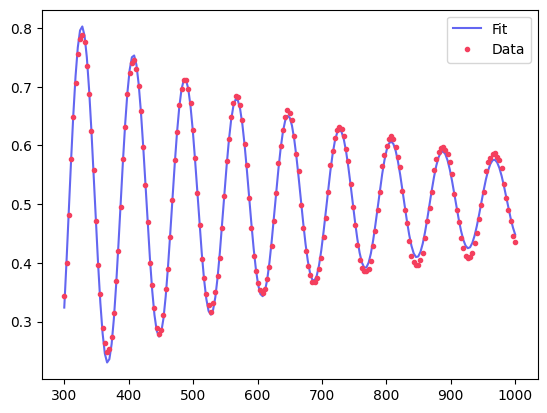

In [25]:

plt.plot(
    t_range,
    fited,
    label="Fit",
    color=sq.utils.colors.blue
)

plt.plot(
    t_range,
    sq.utils.expectation_value_to_prob_minus(expval_z),
    ".",
    label="Data",
    color=sq.utils.colors.red
)

plt.legend()

In [11]:
optimized_param

{'A': Array(0.71364128, dtype=float64),
 'B': Array(0.50139, dtype=float64),
 'T2': Array(449.91757256, dtype=float64),
 'omega_m': Array(0.07752186, dtype=float64),
 'phi': Array(-0.03742623, dtype=float64)}

Even fancier, we can do bayesian inference for the model parameters.

In [12]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive, init_to_sample

In [13]:
def probabilistic_model(t_eval, observed: None = None):
    A = numpyro.sample("A", numpyro.distributions.Normal(0.8, 0.05))
    B = numpyro.sample("B", numpyro.distributions.Normal(0.5, 0.05))
    omega_m = numpyro.sample(
        "omega_m",
        numpyro.distributions.Normal(jnp.pi * qubit_info.frequency * 0.005, 0.001),
    )
    T2 = numpyro.sample("T2", numpyro.distributions.Normal(500.0, 20.))
    phi = numpyro.sample("phi", numpyro.distributions.Normal(0.0, 0.01))

    predicted = exponential_decay_cosine_model(t_eval, A, B, omega_m, T2, phi)

    numpyro.sample(
        "population",
        numpyro.distributions.TruncatedNormal(predicted, 0.05, low=0.0, high=1.0),  # type: ignore
        obs=observed,
    )


mcmc = MCMC(NUTS(probabilistic_model, init_strategy=init_to_sample), num_warmup=1000, num_samples=1000)
mcmc.run(jax.random.key(0), t_range, sq.utils.expectation_value_to_prob_minus(expval_z))

samples = mcmc.get_samples()
population_samples = Predictive(
    probabilistic_model, posterior_samples=samples, num_samples=1000
)(jax.random.key(0), t_range)["population"]

mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:28<00:00, 70.41it/s, 255 steps of size 1.56e-02. acc. prob=0.95] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      0.60      0.03      0.60      0.57      0.65    404.09      1.00
         B      0.50      0.00      0.50      0.50      0.51    606.99      1.00
        T2    471.41     16.80    470.99    442.81    497.49    359.04      1.01
   omega_m      0.08      0.00      0.08      0.08      0.08    820.24      1.00
       phi     -0.01      0.01     -0.01     -0.03      0.01    452.09      1.00

Number of divergences: 0


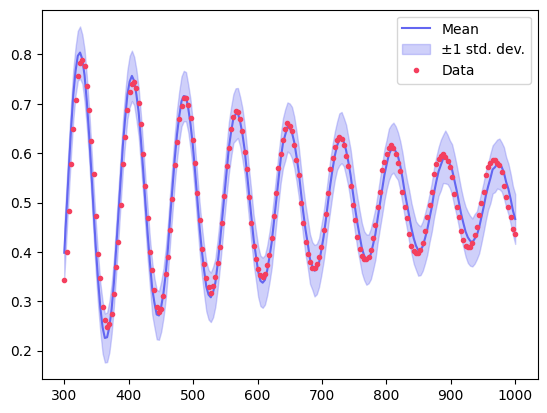

In [24]:


mean_pred = np.mean(population_samples, axis=0)
std_pred = np.std(population_samples, axis=0)

plt.plot(
    t_range,
    mean_pred,
    "-",
    label="Mean",
    color=sq.utils.colors.blue
)
plt.fill_between(
    t_range,
    mean_pred - std_pred,
    mean_pred + std_pred,
    color=sq.utils.colors.blue,
    alpha=0.3,
    label="±1 std. dev.",
)

plt.plot(
    t_range,
    sq.utils.expectation_value_to_prob_minus(expval_z),
    ".",
    label="Data",
    color=sq.utils.colors.red
)

plt.legend()

array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'B'}>,
        <Axes: title={'center': 'T2'}>],
       [<Axes: title={'center': 'omega_m'}>,
        <Axes: title={'center': 'phi'}>, <Axes: >]], dtype=object)

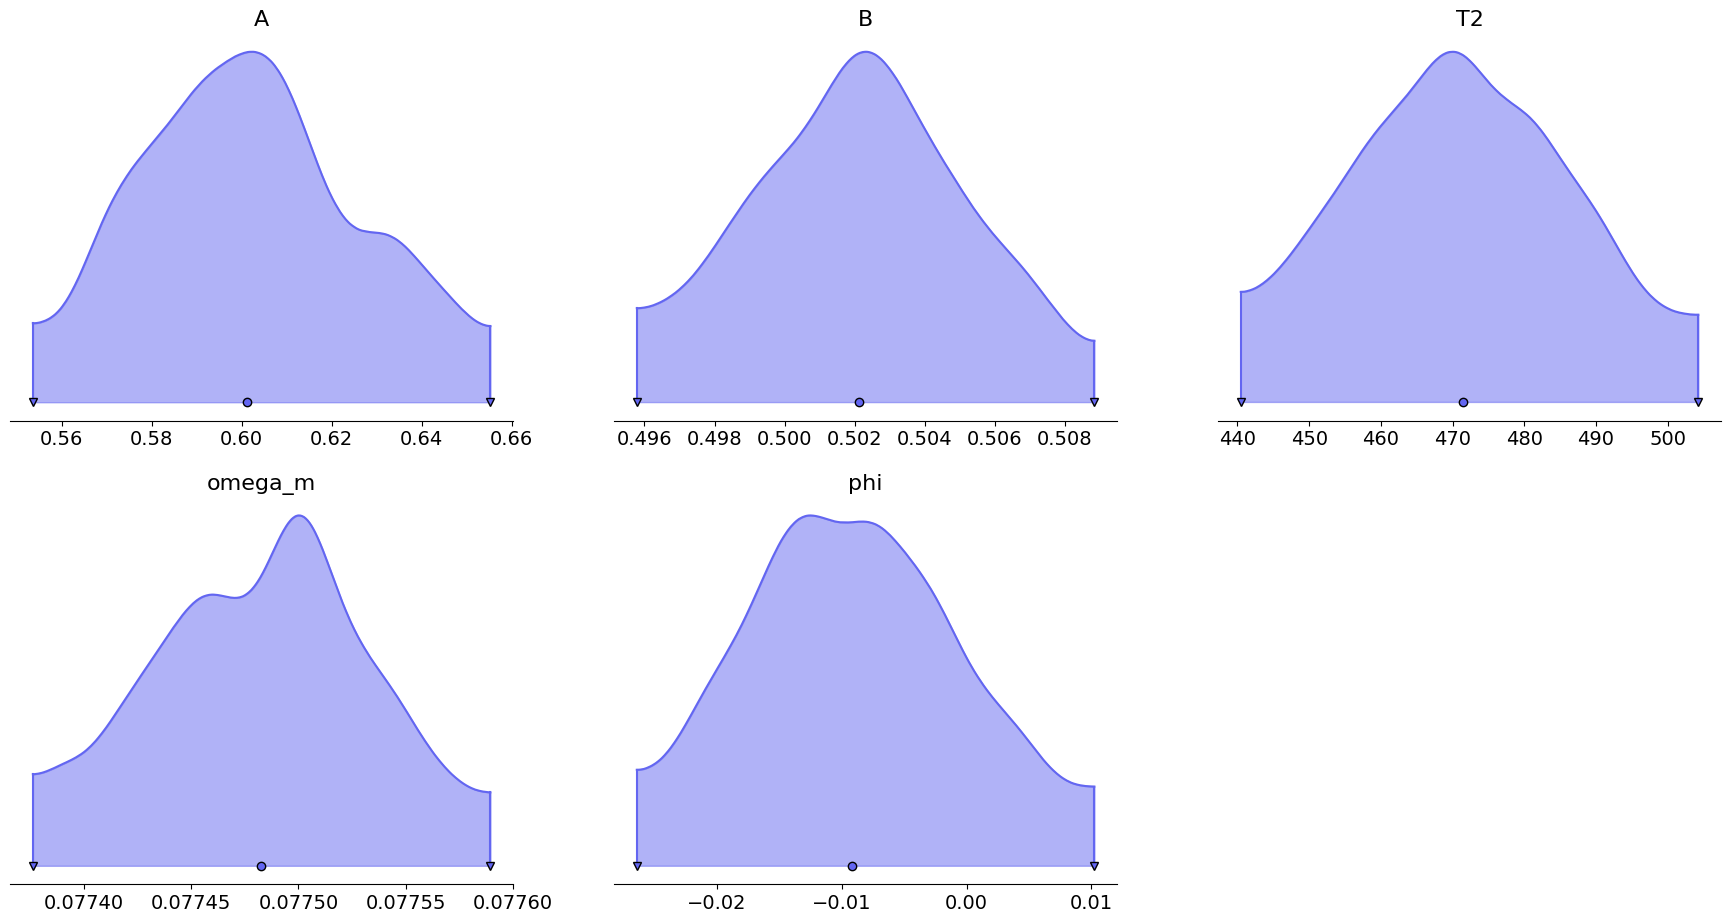

In [35]:
import arviz

arviz.plot_density(
    samples, shade=0.5, hdi_markers="v", hdi_prob=0.95, colors=sq.utils.colors.blue
)